In [2]:
import numpy as np
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

### Funciones del benchmark (adaptadas a 1D)
Extraídas de https://www.sfu.ca/~ssurjano/optimization.html

Están escaladas para adaptar el dominio que recomienda la página web al dominio $[-1,1]$

In [44]:
# scale Escala x definido en [a,b] para que tenga dominio [a2, b2]
scale = lambda x, a, b, a2, b2: (x-a)*(b2-a2)/(b-a)+a2
scale_from_unity = lambda x, a, b: scale(x, -1,1,a,b)

f = lambda x: np.sin(x)+0.1*np.pi+np.sin(2+x)

#perm beta domain is already [-1,1]
def perm_beta(x, b = 0):
    return (1+b)*(x-1)**2
perm_beta.__name__ = "pbeta"

def zakharov(x):
    #zakharov domain is [-5,10]
    x = scale_from_unity(x,-5,10)
    return 5*x**2/4 + np.power(x,4)/16
zakharov.__name__ = "zkrv"

def forrester(x):
    #forrester domain is [0,1]
    x = scale_from_unity(x,0,1)
    return (6*x-2)**2*np.sin(12*x-4)
forrester.__name__ = "fstr"

# b = 8,18,44,114 is advised (?)
def powersum(x, b=8):
    #powersum domain is [0,1]
    x = scale_from_unity(x,0,1)
    return (x-b)**2
powersum.__name__ = "pwrsm"

# m is steepness (de las "fosas"). m = 10 is advised
def michalewicz (x,m=10):
    #domain is [0, pi]
    x = scale_from_unity(x,0,np.pi)
    return -np.sin(x)*np.power((np.sin(x**2/np.pi)), 2*m)
michalewicz.__name__ = "mich"

def schwefel(x):
    #domain is [-500,500]
    x = scale_from_unity(x,-500,500)
    return 418.9829-x*np.sin(np.sqrt(np.abs(x)))
schwefel.__name__ = "schwfl"

def rastrigin(x):
    #domain is [-5.12,5.12]
    x = scale_from_unity(x,-5.12,5.12)
    return 10 + x**2 - 10*np.cos(2*np.pi*x)
rastrigin.__name__ = "rstrgn"

def levy(x):
    #domain is [-10,10]
    x = scale_from_unity(x,-10,10)
    return np.sin(x)**2 + (x-1)**2*(1 + 10*np.sin(np.pi*x+1)**2)

def griewank(x):
    #domain is [-600,600]
    x = scale_from_unity(x,-600,600)
    return x**2/4000-np.cos(x)+1
griewank.__name__ = "grwnk"

def gramacy(x):
    #domain is [-0.5,2.5]
    x = scale_from_unity(x,-0.5, 2.5)
    return np.sin(10*np.pi*x)/(2*x) + np.power(x-1, 4)
gramacy.__name__ = "grmcy"

**Future Lucia**: Ya no quiero borrarlo dsps de escribirlo todo, pero para la prox y para más dimensiones mira https://pypi.org/project/PyBenchFCN/0.0.3/
### Dibujando funciones para ver qué pinta tienen

In [4]:
namer = lambda t: t.__name__
vnamer = np.vectorize(namer)

Text(0.5, 1.0, 'Benchmark function gramacy')

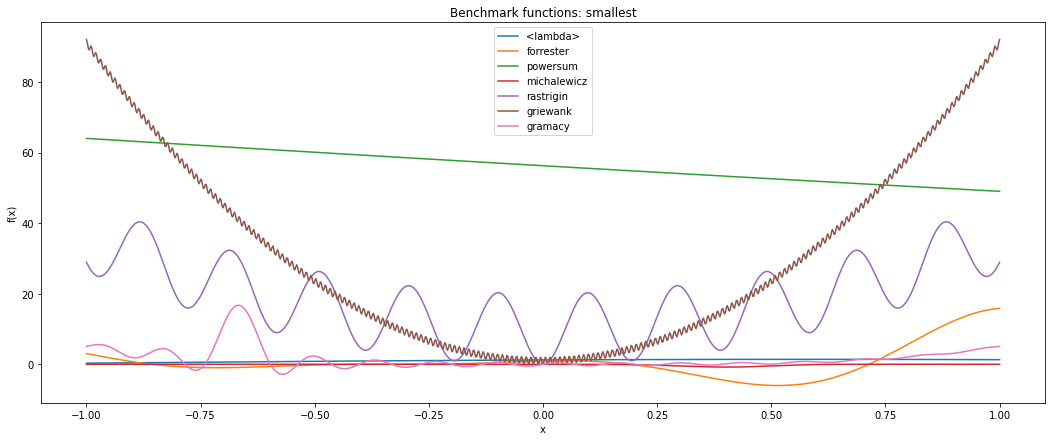

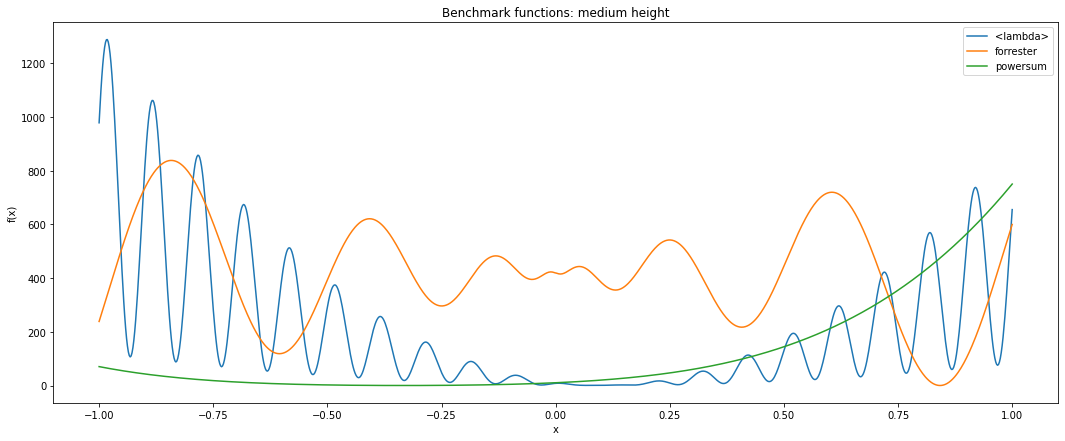

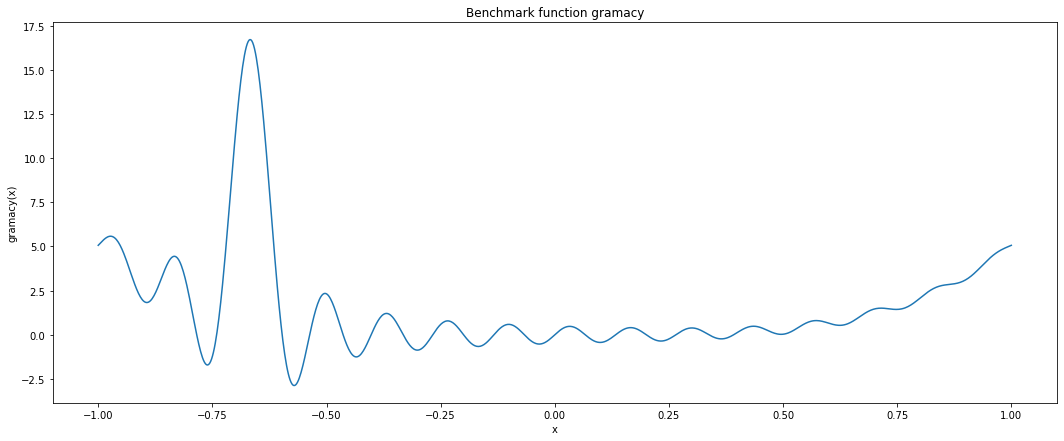

In [34]:
functions = [f, forrester, powersum, michalewicz, rastrigin, griewank, gramacy]
functions2= [levy, schwefel, zakharov]
X = np.linspace(-1, 1, 1000)[:,None]

#First figure
plt.figure(figsize=(18, 7))
for fn in functions: 
    plt.plot(X, fn(X))
# Annotate plot
plt.xlabel("x"), plt.ylabel("f(x)") 
plt.title("Benchmark functions: smallest")
plt.legend(labels=vnamer(functions));

#Second figure (functions with higher values)
plt.figure(figsize=(18, 7))
for fn in functions2: 
    plt.plot(X, fn(X))
# Annotate plot
plt.xlabel("x"), plt.ylabel("f(x)") 
plt.title("Benchmark functions: medium height")
plt.legend(labels=vnamer(functions));

plt.figure(figsize=(18, 7))
plt.plot(X, gramacy(X))
# Annotate plot
plt.xlabel("x"), plt.ylabel("gramacy(x)") 
plt.title("Benchmark function gramacy")

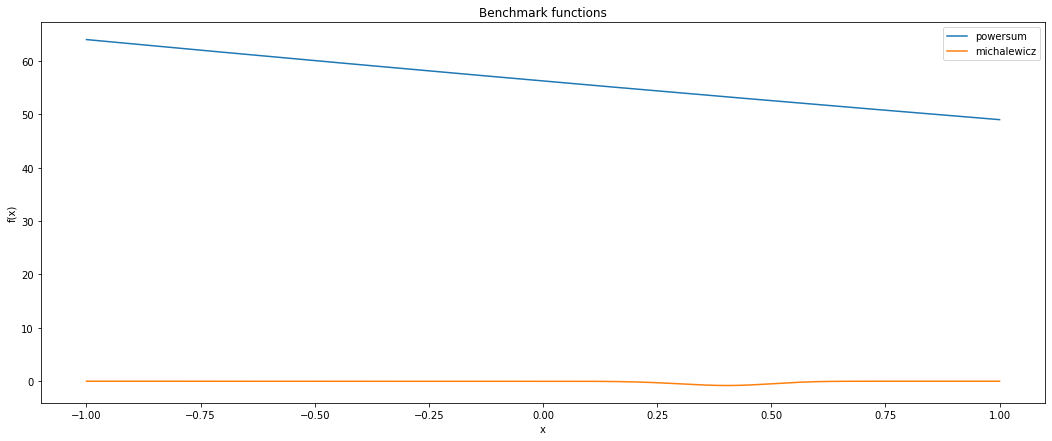

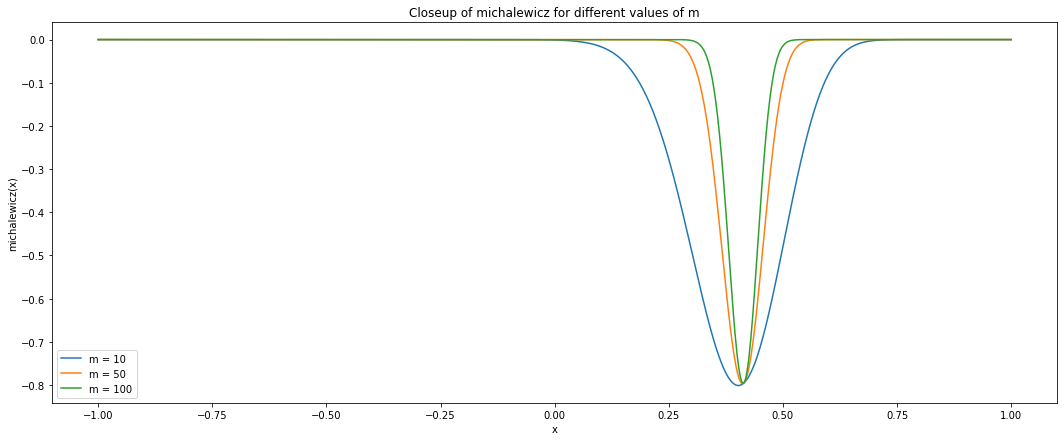

In [20]:
# These ones seemed the most similar in the upper figure
functions3= [powersum, michalewicz]
#Third figure
plt.figure(figsize=(18, 7))
for fn in functions3: 
    plt.plot(X, fn(X))
# Annotate plot
plt.xlabel("x"), plt.ylabel("f(x)") 
plt.title("Benchmark functions")
plt.legend(labels=vnamer(functions3));



plt.figure(figsize=(18, 7))
plt.plot(X, michalewicz(X))
plt.plot(X, michalewicz(X, 50))
plt.plot(X, michalewicz(X, 100))
# Annotate plot
plt.xlabel("x"), plt.ylabel("michalewicz(x)") 
plt.title("Closeup of michalewicz")
plt.title("Closeup of michalewicz for different values of m")
plt.legend(labels = ["m = 10", "m = 50", "m = 100"])

### Next step: least squares to find best affine transformation + write down/ implement thoughts

#### Initial idea: choose a transformation $T$ and a way to measure distance wrt that transformation
For example:
1. I can decide that 2 functions $f_1$, $f_2$ are identical if they are proportional, or if you can obtain $f_2$ graph from $f_1$ by translating $f_1$ on the $y-$axis or the $x-$axis 

Ideally, I'd like to consider the closest affine transformations $Y = AX + b$, but I dont know if there is a way to find the best $A$, $b$ or if it would take any real big matrix inversion if dimension of X is high. For now, I model the case when $f_2(x) = af_1(x) + b$ and find suitable $a, b$ to minimize mean square error

2. Decide how distance between $f_2$ and $T(f_1)$. } is measured. For example:
    1. $\#\{x$ such that $|f_2(x) - T(f_1(x)| > \delta\}$
    2. $\%\{x$ such that $|f_2(x) - T(f_1(x)| > \delta\}$
    3. $\sum_{f_2 - Tf_1 > \delta}{|f_2(x) - Tf_1(x)|}$
    4. Previous one but with any other distance (euclidean eg)
    5. This is not a mathematical distance (assimetry), but same as C. but without abs values? So that a flattened cosine is similar to $y = 0$ (For this option it would suffice to set $\delta = flat\_cos(0)$)
    6. Max difference (norma infinito)
    7. Mean difference

In [37]:
# Various distance definitions 

#A
def npoints_more_than(m1, m2, delta = 0):
    return (np.abs(m1-m2)>delta).sum()
#B
def percentage_more_than(m1, m2, delta = 0):
    return 100*(np.abs(m1-m2)>delta).sum()/len(m1)
#C
def sum_difference(m1, m2, delta = 0):
    return np.abs(m1-m2)[np.where(np.abs(m1-m2) > delta)].sum()
#F delta not needed. Just added to fit the mean_dist method called from below
def max_difference(m1, m2, delta = 0):
    return np.amax(np.abs(m1-m2))
#G delta not needed
def avg_difference(m1,m2, delta = 0):
    return np.abs(m1-m2).sum()/len(m1)
# Error cuadratico
def quad_error(m1,m2, delta=0):
    return np.linalg.norm(m1-m2)
    

# Transformations
from scipy.optimize import curve_fit

#line = lambda x, a, b: a*x + b
def line(x, a, b):
    return a * x + b
#finds best a, b such that gp2 = a*gp1 + b
def line_transform(m1, m2, X):
    popt, pcov = curve_fit(line, m1, m2)
    #print(popt)
    Tm1 = line(m1, popt[0], popt[1])
    return Tm1


In [6]:
'''
* gp1, gp2 are the processes to be predicted over the domain X
* epsilon \in [0,1] is the weight that will be given in the final distance to the distance between gp1 and gp2 means
(versus 1 - epsilon, which will be the weight given to the distance between their variance)
* transformation is a function with respect to which we decide if mean1 and mean2 are similar.
i.e., distance(mean1, mean2) = 0 iff mean2 = transformation(m1). (transformation could be calculated as a curve fit)
* var_dist and mean_dist are functions to define the distance between both mean vectors/ variance vectors
* delta is a number used as an argument in mean_dist to decide when the distance between two values is negligible. 
e.g., mean_dist(m1,m2) = sum(|m1-m2| when |m1-m2|> delta)
'''
def distance(gp1, gp2, X, epsilon = 0.5, delta = 0.1, 
             transformation = line_transform, 
             mean_dist = max_difference, 
             var_dist = sum_difference):
    
    m1, v1 = gp1.predict_noiseless(X, full_cov = True)
    m2, v2 = gp2.predict_noiseless(X, full_cov = True)
    Tm1 = transformation(m1, m2, X)
    
    d1 = mean_dist(Tm1, m2, delta)
    # Escribo delta = 0 x1, asumiendo que las varianzas son valores pequeños, solo tendria sentido
    # escribir delta peque. Puedes probar con otros valores (delta2?) si las varianzas son grandes
    d2 = var_dist(v1, v2, 0)
    
    return epsilon*d1 + (1-epsilon)*d2
    

En el siguiente ejemplo veo como se comporta la distancia con line_transform al intentar comparar dos michalewicz con distinta m. (m = 10 y m = 100)

Cuando tomo $\delta > 0.6$, que es la altura de la transformacion escogida por minimos cuadrados (mira la grafica inferior) la funcion distancia dice que $Tf_1$ y $f_2$ se parecen mas que $f_1$ y $f_2$. Con un $\delta$ menor, $f_1$ y $f_2$ se parecen mas que $Tf_1$ y $f_2$

[ 1.24164986 -0.06042908]
npoints_more_than     (f1, f2) = 184    (Tf1, f2) = 166 
percentage_more_than  (f1, f2) = 18.4   (Tf1, f2) = 16.6
sum_difference        (f1, f2) = 63.38  (Tf1, f2) = 50.35
max_difference        (f1, f2) = 0.6    (Tf1, f2) = 0.53
avg_difference        (f1, f2) = 0.07   (Tf1, f2) = 0.1 


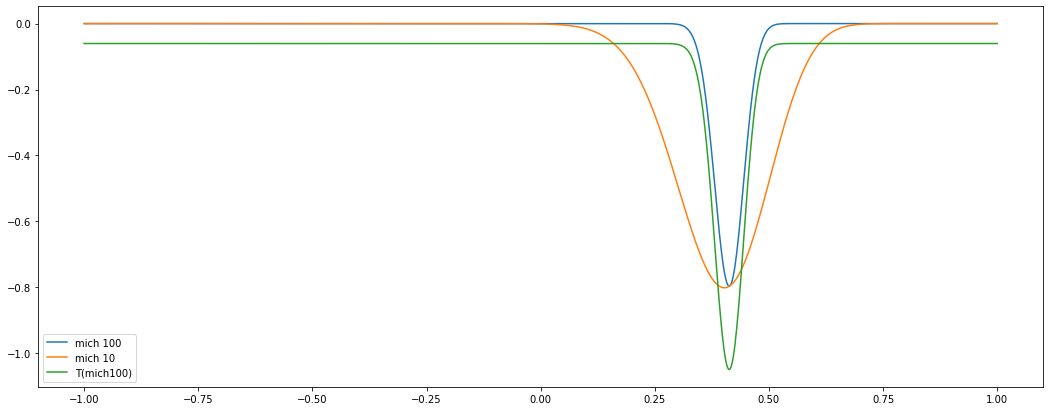

In [36]:
X = np.linspace(-1, 1, 1000)
f1 = michalewicz(X, 100)
f2 = michalewicz(X, 10)
Tf1 = line_transform(f1,f2,X)

plt.figure(figsize=(18, 7))
plt.plot(X, f1, label = "mich 100")
plt.plot(X, f2, label = "mich 10")
plt.plot(X, Tf1, label = "T(mich100)")
plt.legend()
distances = [npoints_more_than, percentage_more_than, sum_difference, max_difference, avg_difference]
for dist in distances:
    line_new = '{:<20}  {:<16}  {:<16}'.format(dist.__name__, "(f1, f2) = "+ str(round(dist(f1, f2, 0.1),2)), "(Tf1, f2) = " + str(round(dist(Tf1, f2, 0.1),2)))
    print(line_new)

**No es simétrico :(**

In [44]:
Tf1 = line_transform(f1,f2,X)
Tf2 = line_transform(f2,f1,X)

quad_error(Tf1, f2, 0.1)

[ 1.24164986 -0.06042908]
[0.44769218 0.01297614]


4.555319760100478

In [45]:
quad_error(Tf2, f1, 0.1)

2.463368241157879

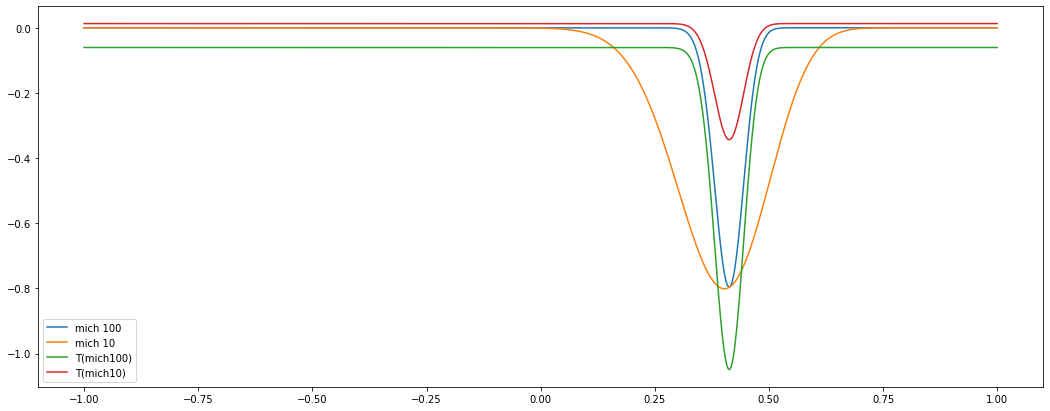

In [47]:
plt.figure(figsize=(18, 7))
plt.plot(X, f1, label = "mich 100")
plt.plot(X, f2, label = "mich 10")
plt.plot(X, Tf1, label = "T(mich100)")
plt.plot(X, Tf2, label = "T(mich10)")

plt.legend()

In [50]:
import math 
X = np.linspace(-1, 1, 100)
fs = [perm_beta, zakharov, forrester, powersum, michalewicz, schwefel, rastrigin,levy, griewank, gramacy]
row_format ="{:>8}" * (len(fs) + 1)
print(row_format.format("", *vnamer(fs)))

for f1 in fs:
    distances = []
    y1 = f1(X)
    for f2 in fs:
        y2 = f2(X)
        Ty1 = line_transform(y1,y2,X)
        distances.append(str(round(max_difference(Ty1, y2, 0.1),2)))
    print(row_format.format(f1.__name__, *distances))   
    

           pbeta    zkrv    fstr   pwrsm    mich  schwfl  rstrgn    levy   grwnk   grmcy
   pbeta     0.0   512.8   14.59    2.61    0.64  356.77   23.64  792.62   68.07   13.41
    zkrv    2.47     0.0    7.37    6.79     0.7   392.4   23.57 1080.31   64.95   14.93
    fstr    2.75   250.2     0.0    8.32    0.59  407.62   21.77  1030.1   52.17   14.85
   pwrsm    0.62  400.91   13.18     0.0    0.65  358.66   21.79  918.67   61.18   13.86
    mich    2.46  625.31   14.32    7.96     0.0  428.55   20.68 1031.03   57.05    14.3
  schwfl    2.99  678.01   16.67     8.9    0.68     0.0   21.61 1069.24   60.38   14.21
  rstrgn    2.44  548.53   13.87    7.61    0.65  418.58     0.0  976.06   44.01   13.11
    levy    2.52  594.36   15.16    9.65    0.67  426.43   23.34     0.0   59.49   13.89
   grwnk    2.01  378.66    9.77     7.5    0.67  418.58   11.47   670.3     0.0   13.99
   grmcy    2.24  592.98   14.01    8.32    0.68  446.78   20.67  929.27   54.86     0.0


In [25]:
gramacy(-1)

nan

In [28]:
x = 0
np.sin(10*np.pi*x)/(2*x) + np.power(x-1, 4)

nan